<a href="https://colab.research.google.com/github/fantajeon/DLPytorch1.2/blob/master/Chapter1_MiniBatch%EC%99%80_SGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#MiniBatch와 SGD#
Author: fantajeon@gmail.com

이번 시간에는 MiniBatch에 대해서 알아보겠습니다. 이것은 우선 Gradient Descent에서부터 시작을 해보겠습니다.

## Gradient Descent ##
Gradient Descent에서는 전체 훈련셋으로부터 gradient을 계산했습니다. 그런데 여기서 큰 문제가 하나 있습니다. 이 상황을 생각해 봅시다. 메모리에 적재(할당)할 수 없을 정도로 매우 크면 어떻게 해야 하나요? 적제를 할 수 없기 때문에 gradient도 역시 계산을 못할 것입니다. 비록 메모리에 적재까지는 해도, gradient를 계산할때 메모리 한계로 계산 불가이면 어떻게 할까요? 그래서 바로 쉽게 생각할 수 있는 대안은 일부분만으로 해보자! 이 일부분은 크기는 어디까지 일까? 이 문제는 ML 설계자에게 고질적으로 따라다는 문제로 남아있습니다.

## Mini Batch와 Stochastic Gradient Descent Optimization ##
일 부분을 취하면 Gradient Descent를 하기때문에 별도의 이름이 있습니다. 바로 Stochastic Gradient Descent(SGD)입니다. 자 그럼 루프 구조를 먼저 언급하고 코드로 바로 가겠습니다.
1. (epoch loop) 전체 훈련셋을 20번 학습한다.
  1. (mini batch loop) 전체 훈련셋으로부터 n개씩 일부분을 차근차근 서브 샘플(MiniBatch라 한다)을 추출한다.
    1. Predict: MiniBatch 단위로 $\hat {y} = f(x)$을 예측한다.
    2. Loss: Loss(y, $\hat {y}$)를 계산한다.
    3. Gradient 계산: Backward()를 사용하여 gradient를 계산한다.
    4. 인자 갱신, step: Optimizer.step()으로 $f(x)$, 즉 모델의 인자를 갱신한다.

### 용어설명 ###
**poch**는 전체 훈련셋을 몇 번 학습할 것인지를 지정합니다. 이게 생긴것은 MiniBatch때문에 생긴것입니다. 일부를 학습하지만, 빼먹는 샘플은 없어야 합니다. 그리고 일부분으로 gradient를 계산한 것이기 때문에, 오차가 있기 때문에 최적화하는 데 시간이 더 필요합니다.

**MiniBatch**는 훈련셋중 이번에 학습할 샘플입니다. 보통은 학습시킬 훈련셋의 따라서 적당한 양은 직접 찾아야 합니다. 그러나 물리적인 메모리와 학습 속도를 관찰하다보면, 현실적으로 가능한 수치들이 있을 겁니다. 보통은 32, 64, 128, 256, 1024 중에 하나로 합니다. 

# 강좌를 위해서 큰 훈련셋을 마련 해보자 #

In [0]:
#필요한 모듈 초기화
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn

## 실험을 위해서 시뮬레이션 데이터 생성 ##

In [8]:
w = 110.0
b = 5.5

torch.manual_seed(0)  # 랜덤이긴하지만, 실험 재현 목적으로 0을 임의적으로 설정
x = torch.linspace(0,1,steps=102400)
y = w*x + b + torch.randn( x.size() ) * 30.0  # 잡음 추가

print("x의 개수", x.size())
print(y[0:10])

x의 개수 torch.Size([102400])
tensor([-28.2752, -29.0697,  -2.0152,  -7.5131,  30.9656,  26.2656,  -3.9739,
        -57.9491,  15.1768, -32.3904])


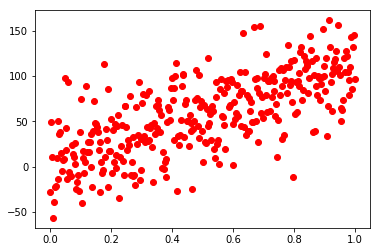

In [9]:
# 이제 어떤 모양인지 300개 간격으로 그래프를 그려 보겠습니다.

# numpy는 공학자들이 많이 쓰는 공학용 계산 framework입니다. PyTorch는 Numpy와 호환이 잘 되도록 설계되었습니다.
x_numpy = x[::300].numpy()   
y_numpy = y[::300].numpy()
# 아래에 detach는 연산을 기록하는 computation graph에서 때낸다. 향후 어떠한 연산을 해도 그래프에 기록되지 않을 것입니다.
plt.plot(x_numpy,y_numpy,'ro')

# Stochastic Gradient Descent #
자 이제 코드를 구현해 보겠습니다.

In [10]:
#nn.Module화 하기
class Model(nn.Module): # 1. 상속
  def __init__(self):   # 2. 모듈 초기화 구현
    super(Model, self).__init__()
    self.w = nn.Parameter( torch.rand(1, dtype=torch.float) )   # 모델의 w 인자 정의(이런게 있군요 눈으로만 여겨 보자!)
    self.b = nn.Parameter( torch.rand(1, dtype=torch.float) )   # 모델의 b 인자 정의

  def forward(self, x): # 3. forward()구현
    return self.w * x + self.b

model = Model()
loss = nn.MSELoss(reduction='sum')


epoch = 20
mini_batch = 1024
learning_rate = 1e-4
optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate)

L_list = []

nsample = x.size(0)
max_step = nsample // mini_batch
print("훈련셋 개수", nsample, ", minibatch 반복문 회수", max_step)
L_sum = 0
for e_iter in range(epoch):  # epoch loop
  for step in range(max_step):   # minibatch loop
    mini_batch_x = x[ step*mini_batch:(step+1)*mini_batch]
    mini_batch_y = y[ step*mini_batch:(step+1)*mini_batch]
    pred_y = model(mini_batch_x)
    L = loss(pred_y, mini_batch_y)
    L_sum += L
    optimizer.zero_grad() 
    L.backward()
    optimizer.step()

    if step % 50 == 0:
      print("Epoch:{}/Step:{}, L:{:.5}, w={}, b={:.3}, grad(w)={:.3}, grad(b)={:.3}".format(e_iter, step, L.item(), model.w.item(), model.b.item(), model.w.grad.item(), model.b.grad.item()))
    step += 1
  print("==> End Epoch #{}, loss=L:{:.5}".format(e_iter, L_sum/max_step))


훈련셋 개수 102400 , minibatch 반복문 회수 100
Epoch:0/Step:0, L:1.0108e+06, w=0.36468106508255005, b=2.14, grad(w)=-58.8, grad(b)=-1.26e+04
Epoch:0/Step:50, L:9.1485e+05, w=12.78161334991455, b=51.6, grad(w)=-3.56e+03, grad(b)=-7.04e+03
==> End Epoch #0, loss=L:9.4039e+05
Epoch:1/Step:0, L:6.4718e+06, w=33.33009338378906, b=65.1, grad(w)=7.54e+02, grad(b)=1.5e+05
Epoch:1/Step:50, L:9.0836e+05, w=39.08966827392578, b=39.1, grad(w)=-2.45e+03, grad(b)=-4.84e+03
==> End Epoch #1, loss=L:2.0138e+06
Epoch:2/Step:0, L:3.8635e+06, w=54.019134521484375, b=49.0, grad(w)=5.48e+02, grad(b)=1.09e+05
Epoch:2/Step:50, L:9.0513e+05, w=58.2474365234375, b=30.0, grad(w)=-1.64e+03, grad(b)=-3.24e+03
==> End Epoch #2, loss=L:3.0172e+06
Epoch:3/Step:0, L:2.4873e+06, w=69.0851821899414, b=37.3, grad(w)=3.99e+02, grad(b)=7.88e+04
Epoch:3/Step:50, L:9.0356e+05, w=72.1983871459961, b=23.4, grad(w)=-1.05e+03, grad(b)=-2.07e+03
==> End Epoch #3, loss=L:3.9833e+06
Epoch:4/Step:0, L:1.7627e+06, w=80.05648040771484, b=28.7,

## 결과 분석 ##
실제 우리가 예상한 $w$와 $b$값을 110과 5.5였습니다. 잡음을 섞어서 정확히 추정을 어려울 것입니다. 그러나 근사한 값은 얻었습니다. $w$와 $b$의 SGD로 추정한 값은 각각 109와 6 이기 때문입니다.

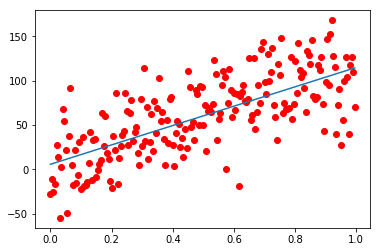

In [13]:
# 이제 어떤 모양인지 512개 간격으로 그래프를 그려 보겠습니다.

# numpy는 공학자들이 많이 쓰는 공학용 계산 framework입니다. PyTorch는 Numpy와 호환이 잘 되도록 설계되었습니다.
x_numpy = x.numpy()[::512]   
y_numpy = y.numpy()[::512]
pred_y = model(x).detach().numpy()[::512]

# 아래에 detach는 연산을 기록하는 computation graph에서 때낸다. 향후 어떠한 연산을 해도 그래프에 기록되지 않을 것입니다.
plt.plot(x_numpy,y_numpy,'ro')
plt.plot(x_numpy,pred_y,label='Fitted line')

# Dataset + DataLoader + Compose를 하면 병렬화가되는 하나의 파이프라인이 완성 #
1. Dataset 구현
2. DataLoader 활용
3. Transform구현과 Compose 활용

이 모든 과정은 하나의 파이프라인으로 만들어서 일괄적으로 처리하여 훈련셋 학습 과정을 효과적으로 하자 입니다. 이것을 한 이유는 실제 현장에서 처리하다보면 데이터 사이즈가 방대합니다. 이럴 경우 병렬처리 분산처리등을 동원하여 학습을 해야 합니다. 그럴려면 약간의 규약을 지켜주면 복잡한 구현없이 개발자는 이 유용한 기능들을 사용할 수 있습니다.

# PyTorch의 DataSet Loader 구현 #
자 그럼 조금 더 PyTorch framework에 알맞게 구조화를 시켜 보겠습니다. PyTorch에서는 pytorch.utils.data.Dataset라는 클래스를 제공합니다. 이것은 추상클래스입니다. 역할 명세서 정의는 되어있지만, 실제적으로 작동부분에 해당하는 구현이 없는 껍데기 클래스입니다. 저의가 할 일을은 Dataset의 부족한 부분을 구현해주면 됩니다. 보통 구현할 내용은 다음과 같습니다:
1. \__init__(): Dataset이 만들어질때 필요한 부분입니다. 파일로부터 메모리에 적재하는 과정을 구현합니다.
2. \__len__(): 데이터셋의 크기를 반환합니다. 전체 루프를 돌때 필요한 부분입니다.
3. \__getitem__(): 데이터셋의 접근할 수 있는 방법입니다. 인자로 idx를 받으며, 배열 접근처럼 가능해집니다. 
4. DataLoader 클래스와 같이 활용한다.

Dataset을 구현할때 일부분만 메모리에 적재하도록 짜는 역할은 개발자의 몫입니다. 안타깝지만 자동은 없습니다.


보통은 파일로 저장하고 읽기를 하니다. 그래서 2가지로 코드 구현을 해보겠습니다.
# x,y데이터를 csv형식의 파일로 저장 #

In [19]:
# 실험을 위해서 x, y를 csv형식의 파일로 저장을 하겠습니다.
with open("x.csv", "w") as f:
  for v in x.numpy():
    f.write("{}\n".format(v))

with open("y.csv", "w") as f:
  for v in y.numpy():
    f.write("{}\n".format(v))

print("x.csv의 상위 10개")
!head -n 10 x.csv
print("y.csv의 상위 10개")
!head -n 10 y.csv

x.csv의 상위 10개
0.0
9.765720278664958e-06
1.9531440557329915e-05
2.929715992650017e-05
3.906288111465983e-05
4.882860230281949e-05
5.859431985300034e-05
6.836004467913881e-05
7.812576222931966e-05
8.789147977950051e-05
y.csv의 상위 10개
-28.275196075439453
-29.069730758666992
-2.0152087211608887
-7.513141632080078
30.965608596801758
26.26564598083496
-3.973937511444092
-57.94906234741211
15.176841735839844
-32.390377044677734


# csv 파일을 Dataset으로 적제 #
보통은 파일로부터 다 읽어 들이지 않고, 일부 데이터를 캐싱하면서 처리를 합니다. Dataset의 작동원리를 익히는 것이므로 복잡하지 않게 그냥 다 메모리에 적제해 보도록 하겠습니다.

In [0]:
import torch.utils.data

In [0]:
class MyDataset(torch.utils.data.Dataset):
  def __init__(self, transform=None):
    super(MyDataset, self).__init__()
    self.x = self.load("x.csv")
    self.y = self.load("y.csv")
    self.transform = transform
  
  def load(self, filename):
    data = []
    with open(filename, "r") as f:
      for line in f.readlines():
        line = line.strip()  # 공백제거
        if line == "":
          continue
        data.append( float(line) )
      return torch.tensor(data)
    
  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    if self.transform:  # 변환이 있다면 x를 적용후 반환한다.
      return {'x': self.transform(self.x[idx]), 'y': self.y[idx]}
    return {'x': self.x[idx], 'y': self.y[idx]}

In [145]:
# MyDataset 생성
dataset = MyDataset()
print("len(dataset)", len(dataset))

len(dataset) 102400


## 배열처럼 접근 ##
\__getitem__을 구현하고 반환을 x와 y를 짝을 이루게 반환을 시켰습니다. 파이썬은 여러개를 반환할 수 있는 언어입니다.
1. 하나로 접근도 해본다.
2. 여러개로도 접근해 본다. 이걸 slice방식이라고 합니다.

In [146]:
print("배열처럼 접근", dataset[0])
print("Slice처럼 배열처럼 접근", dataset[0:32])

배열처럼 접근 {'x': tensor(0.), 'y': tensor(-28.2752)}
Slice처럼 배열처럼 접근 {'x': tensor([0.0000e+00, 9.7657e-06, 1.9531e-05, 2.9297e-05, 3.9063e-05, 4.8829e-05,
        5.8594e-05, 6.8360e-05, 7.8126e-05, 8.7891e-05, 9.7657e-05, 1.0742e-04,
        1.1719e-04, 1.2695e-04, 1.3672e-04, 1.4649e-04, 1.5625e-04, 1.6602e-04,
        1.7578e-04, 1.8555e-04, 1.9531e-04, 2.0508e-04, 2.1485e-04, 2.2461e-04,
        2.3438e-04, 2.4414e-04, 2.5391e-04, 2.6367e-04, 2.7344e-04, 2.8321e-04,
        2.9297e-04, 3.0274e-04]), 'y': tensor([-28.2752, -29.0697,  -2.0152,  -7.5131,  30.9656,  26.2656,  -3.9739,
        -57.9491,  15.1768, -32.3904,  16.0102,  14.7558,   9.1081,  42.6437,
         39.0184,  -1.9022, -35.0624, -45.3597,  22.5189,  29.3257,  23.4867,
        -41.1303,  -4.7172,  61.1149,  28.0315, -12.0381,   0.3260,  11.0333,
         47.2111,  53.1212,  33.9212, -19.7770])}


##  MyDataset, DataLoader를 활용해서 SGD에 붙여보자 ##

크게 바뀐 코드는 없습니다. 기존에 x,y를 쓰던것을 Dataset으로 교체되었습니다. 이것으로 실제 구현 파트가 잘 캡슐화되어 활용하는 입장에서는 고민하지 않고 쓰게 됩니다. 내부적으로 훈련셋을 증폭하기 위해서 잡음을 섞거나, 순서를 무작위로 변경하고나, 캐시하는 등 복잡한 과정이 숨겨지는 장점이 있습니다.

### DataLoader ###
DataLoader는 Dataset과 mini batch의 크기를 받아서, 훈련할 수 있는 mini batch크기에 훈련셋을 반환해 주는 반복자입니다. 또한 가끔은 처리보다 파일에서 메모리로 적제하는게 느린 경우가 있습니다. 학습 처리 속도에 지장을 최소화 하도록 병렬로 처리를 합니다. 물론 자원이 충분해야 합니다. 예를들어 CPU가 4개 달린 머신이어야 합니다. 이 부분도 저희가 전체를 구현없이 가능하도록 DataLoader가 지원합니다.


1. Dataset: 데이터를 파일로부터 읽는 부분
2. batch_size: Mini Batch의 크기
3. shuffle: 훈련셋을 섞는 기능, 매번 같은 훈련셋이 아니도록 만들어 주는 기능. 훈련셋들간에 독립적이 되도록 하는 목적
3. num_workers가 병렬처리의 개수를 지정합니다. 이것은 하나하나씩 Dataset.\_\_getitem\_\_을 호출합니다. 그리고 내부적으로 mini batch크기로 취합처리해서 하나로 반환해 줍니다.


In [147]:
# Model 정의
model = Model()

# Optimizer 설정
epoch = 10
mini_batch = 1024
learning_rate = 1e-4
optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate)

# MyDataset을 구현
dataset = MyDataset()
L_list = []


nsample = len(dataset)
print("훈련셋 개수", nsample)
L_sum = 0

loader = torch.utils.data.DataLoader(dataset, batch_size=mini_batch, shuffle=True, num_workers=4)
for e_iter in range(epoch):  # epoch loop
  for step, mini_batch in enumerate(loader):   # minibatch loop
    pred_y = model(mini_batch['x'])
    L = loss(pred_y, mini_batch['y'])
    L_sum += L
    optimizer.zero_grad() 
    L.backward()
    optimizer.step()

    if step % 50 == 0:
      print("Epoch:{}/Step:{}, L:{:.5}, w={}, b={:.3}, grad(w)={:.3}, grad(b)={:.3}".format(e_iter, step, L.item(), model.w.item(), model.b.item(), model.w.grad.item(), model.b.grad.item()))
    step += 1
  print("==> End Epoch #{}, loss=L:{:.5}".format(e_iter, L_sum/max_step))

훈련셋 개수 102400
Epoch:0/Step:0, L:5.4652e+06, w=8.727423667907715, b=12.6, grad(w)=-7.96e+04, grad(b)=-1.19e+05
Epoch:0/Step:50, L:1.0365e+06, w=68.2392578125, b=27.7, grad(w)=-4.31e+03, grad(b)=5.31e+03
==> End Epoch #0, loss=L:1.2224e+06
Epoch:1/Step:0, L:9.4121e+05, w=89.37413024902344, b=16.8, grad(w)=-4.18e+03, grad(b)=1.56e+02
Epoch:1/Step:50, L:9.2445e+05, w=99.7844009399414, b=11.1, grad(w)=-1.44e+03, grad(b)=9.9e+02
==> End Epoch #1, loss=L:2.1603e+06
Epoch:2/Step:0, L:9.1439e+05, w=104.68040466308594, b=8.01, grad(w)=1.23e+03, grad(b)=2.42e+03
Epoch:2/Step:50, L:8.6979e+05, w=107.48329162597656, b=6.7, grad(w)=1.46e+03, grad(b)=2.96e+03
==> End Epoch #2, loss=L:3.0849e+06
Epoch:3/Step:0, L:9.2409e+05, w=108.84705352783203, b=5.69, grad(w)=5.22e+02, grad(b)=1.42e+03
Epoch:3/Step:50, L:9.216e+05, w=109.58184051513672, b=5.59, grad(w)=-1.57e+03, grad(b)=-1.62e+03
==> End Epoch #3, loss=L:4.0087e+06
Epoch:4/Step:0, L:9.0182e+05, w=110.17737579345703, b=5.38, grad(w)=1.16e+03, grad(

# Transform를 붙여보자 #
PyTorch는 복잡한 변환과정을 쉽게하여 가독성을 높이도록 지원합니다. 물론 사람마다 다르므로, 반듯이 지키실 필요는 없습니다.

MyDataset을 구현할 때 인자로 받을 계획입니다. 이러면 MyDataset외부에 정의된 변환이 적용된 훈련셋에 적용되어서 받을 것입니다. 특히 이것은 영상처리에서 유용하게 쓰입니다. 보통은 Dataset은 미리 정의되어 있고, 변환 방식은 나중에 정의되기 때문입니다. 그리고 이 변환과정이 좀 연산이 많습니다. 병렬처리를 하지 않으면 모델 훈련 속도 저하가 발생합니다. 그래서 병렬처리로 변환을 독립적으로 진행합니다. 이것을 도와주는 것이 DataLoader였습니다.

**Transform은 함수처럼 호출 가능한 클래스**로 구현되어야 합니다. 단 병렬처리가 용이하도록 설계를 해야 합니다. 그래서 **\_\_call_\_**을 구현해야 합니다. 관점은 그냥 함수 구현하듯 구현하시면 됩니다.

변환을 여러단계로 해야 할 경우 모듈화가 되어 상당히 용히 합니다. 변환 과정을 공장처리 과정처럼 체인처럼 묶는 것입니다. 이것을 PyTorch에서는  **transforms.Compose**로 지원을 합니다.

여기서 구현할 것은 랜덤으로 숫자를 추가해주는 방식입니다. 훈련셋에 잡음을 추가해주는 방식이라 할 수 있습니다. 많이 쓰는 방식입니다. 무조건 좋은 것은 아니고 상황에따라서 판단해야 합니다. 타당성보다는  이해를 목적으로 구현을 해보겠습니다.

In [0]:
class AddNoise(object):
  def __init__(self, noise_level):
    self.noise_level = noise_level
  
  def __call__(self, x):
    return x + torch.randn(x.size())*self.noise_level

class ReScale(object):
  def __init__(self, scale):
    self.scale = scale
  
  def __call__(self, x):
    return x*self.scale

In [160]:
add_noise = AddNoise(0.0001)
rescale = ReScale(-1.0)   # 음수값 처리

test_input =  torch.tensor([0.1,0.2], dtype=torch.float32)
print("test_input", test_input)
print("add_noise1 변환", add_noise(test_input))
print("rescale 변한", rescale(test_input))
print("복합 변환:", rescale(add_noise(test_input)))

test_input tensor([0.1000, 0.2000])
add_noise1 변환 tensor([0.0999, 0.2000])
rescale 변한 tensor([-0.1000, -0.2000])
복합 변환: tensor([-0.1000, -0.1999])


## 복합 변환을 Compose로 묶어 버리자! ##

보통은 이러한 변환이 영상처리에 많이 있습니다. 영상 처리는 많은 변환을 가지고 있어서, 사용자가 모든 것을 구현할 필요가 없습니다. 사실 지금 이 예에서는 이정도로 정성과 노력을 들일 필요는 없지만, 추후에 이해 목적으로 사용해 봅시다!

In [150]:
import torchvision.transforms
compose = torchvision.transforms.Compose([add_noise, rescale])
print(compose(test_input))

tensor([ 0.9853, -0.8447])


## Transform과 Compose를 기존 SGD에 붙여 보자##
지금은 매우 비효율적입니다. 이유는 Transform과정이나 캐싱이 불필요하기 때문입니다. 추후에 대용량으로 처리할 때 도움이 될 것입니다. 그때 기억해 내시면 됩니다.

In [165]:
# Model 정의
model = Model()

# Optimizer 설정
epoch = 10
mini_batch = 1024
learning_rate = 1e-4
optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate)

# Compose 정의
add_noise = AddNoise(1e-5)
rescale = ReScale(-1.0)
compose = torchvision.transforms.Compose([add_noise, rescale])


# MyDataset에 compose를 연결한다.
dataset = MyDataset(transform=compose)
L_list = []

nsample = len(dataset)
loader = torch.utils.data.DataLoader(dataset, batch_size=mini_batch, shuffle=True)
print("훈련셋 개수", nsample)
L_sum = 0
for e_iter in range(epoch):  # epoch loop
  for step, mini_batch in enumerate(loader):   # minibatch loop
    pred_y = model(mini_batch['x'])
    L = loss(pred_y, mini_batch['y'])
    L_sum += L
    optimizer.zero_grad() 
    L.backward()
    optimizer.step()

    if step % 50 == 0:
      print("Epoch:{}/Step:{}, L:{:.5}, w={}, b={:.3}, grad(w)={:.3}, grad(b)={:.3}".format(e_iter, step, L.item(), model.w.item(), model.b.item(), model.w.grad.item(), model.b.grad.item()))
    step += 1
  print("==> End Epoch #{}, loss=L:{:.5}".format(e_iter, L_sum/max_step))

훈련셋 개수 102400
Epoch:0/Step:0, L:5.7719e+06, w=-7.136871814727783, b=12.3, grad(w)=8.12e+04, grad(b)=-1.23e+05
Epoch:0/Step:50, L:1.1374e+06, w=-67.78055572509766, b=27.4, grad(w)=6.07e+03, grad(b)=4.48e+03
==> End Epoch #0, loss=L:1.2326e+06
Epoch:1/Step:0, L:9.2984e+05, w=-88.94990539550781, b=16.9, grad(w)=2.71e+03, grad(b)=2.26e+03
Epoch:1/Step:50, L:9.2673e+05, w=-99.90492248535156, b=11.3, grad(w)=3.59e+03, grad(b)=-2.47e+03
==> End Epoch #1, loss=L:2.1709e+06
Epoch:2/Step:0, L:9.3775e+05, w=-104.65281677246094, b=8.22, grad(w)=1.14e+03, grad(b)=-1.07e+03
Epoch:2/Step:50, L:9.0497e+05, w=-107.83969116210938, b=6.47, grad(w)=9.35e+02, grad(b)=-9.86e+02
==> End Epoch #2, loss=L:3.0957e+06
Epoch:3/Step:0, L:9.3068e+05, w=-108.66633605957031, b=6.24, grad(w)=4.52e+02, grad(b)=-1.74e+03
Epoch:3/Step:50, L:8.7983e+05, w=-109.3499526977539, b=5.52, grad(w)=1.41e+03, grad(b)=-2.22e+03
==> End Epoch #3, loss=L:4.0195e+06
Epoch:4/Step:0, L:9.4374e+05, w=-109.9946517944336, b=5.51, grad(w)=-